# Signal density

In this notebook we test the signal density. Let $x$ be a vector (if multidimensional, flatten it) with mode $0$,
 - the $\ell_0$ density is defined to be the number nonzero numbers devided by vector length;
 - the $\ell_1$ density is defined to be the average of absolute values.

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from tqdm import tqdm

In [2]:
path_base = Path('/hpcgpfs01/scratch/yhuang2/merged/')
result_folder = Path('results/signalDensity')
if not result_folder.exists():
    result_folder.mkdir()

## The relation of success rate to min singal 

Text(0, 0.5, 'success rate')

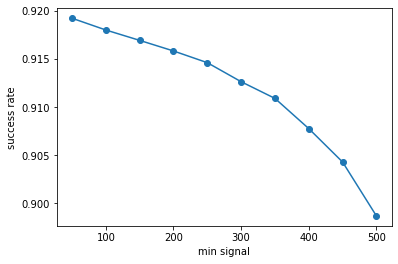

In [3]:
total_pairs = len(list((path_base/'fake').glob('*npz')))

record = []
for window_fname in path_base.glob('windows*.csv'):
    # print(window_fname)
    min_signal = int(Path(window_fname).stem.split('-')[0].split('_')[-1])
    length = pd.read_csv(window_fname).shape[0]
    record.append([min_signal, length])
record = sorted(record)
X, Y = np.array(record).T
plt.plot(X, Y / total_pairs, 'o-')
plt.xlabel('min signal')
plt.ylabel('success rate')

## Function that loads toyzero data

In [4]:
class Dataset_toyzero(Dataset):
    """
    LS4GAN dataset
    """
    def __init__(
        self, 
        data_path,
        window_fname,
        num_samples=None,
        apa=None,   # If not None, must be list 
        planes=None, # If not None, must be list, too
    ):
        super(Dataset_toyzero, self).__init__()
        df_window = pd.read_csv(window_fname, index_col=0)
        
        # select
        if apa is not None:
            df_window = df_window[df_window.apa.isin(apa)]
        if planes is not None:
            df_window = df_window[df_window.plane.isin(planes)]
        if num_samples is not None and num_samples < len(df_window):
            df_window = df_window.sample(n=num_samples, replace=False).reset_index(drop=True)
        self.image_fnames = df_window['image']
        
        data_fake = Path(data_path)/'fake'
        data_real = Path(data_path)/'real'
        
        # Load data
        self.images_fake, self.images_real = [], []
        for index, row in tqdm(df_window.iterrows(), total=df_window.shape[0]):
            image, bkg = row['image'], row['bkg']
            x, y, x_ws, y_ws = row['x'], row['y'], row['width'], row['height']
            image_fake = self._load_image(data_fake/image, x, y, x_ws, y_ws, bkg)
            image_real = self._load_image(data_real/image, x, y, x_ws, y_ws, bkg)
            self.images_fake.append(image_fake)
            self.images_real.append(image_real)
     
    def _load_image(self, image_fname, x, y, x_ws, y_ws, bkg):
        image = np.load(image_fname)
        image = image[image.files[0]]
        image = image[x: x + x_ws, y: y + y_ws] - bkg        
        return image   
        
    def get_images(self):
        return self.image_fnames, np.array(self.images_fake), np.array(self.images_real)

## Load toyzero data with pre-calculated window files

In [5]:
num_samples = 2000
planes = ['U', 'V', 'W']

In [6]:
def get_stat(dataset):
    columns = ['l0 density', 'l1 density', 'min', 'max']
    df_data = []
    for image in dataset:
        image = image.flatten()
        sd_0 = np.mean(image != 0)    
        sd_1 = np.abs(image).mean()
        vmin, vmax = image.min(), image.max()
#         s = image[image != 0]
#         mean, median = s.mean(), np.median(s)
        df_data.append([sd_0, sd_1, vmin, vmax])#, mean, median])
    return pd.DataFrame(data=df_data, columns=columns)

In [7]:
def process_stat(df, min_signal, plane, c):

    df_stat = df[['l0 density', 'l1 density']].copy()
    df_stat = df_stat.describe().loc[['mean', 'std']].unstack().reset_index()
    df_stat['index'] = df_stat['level_0'].astype(str) + ' ' + df_stat['level_1'].astype(str)
    df_stat = df_stat[['index', 0]].set_index('index').T
    
    df_stat['min signal'] = min_signal
    df_stat['plane'] = plane
    df_stat['class'] = c
    
    return df_stat

## Calculate and save statistics
(don't run unless necessary.)

In [ ]:
for window_fname in path_base.glob('windows*.csv'):
    print(window_fname)
    min_signal = int(Path(window_fname).stem.split('-')[0].split('_')[-1])
    print(min_signal)
    
    data_path = path_base
    for plane in planes:
        print(plane)
        image_fnames, images_fake, images_real = Dataset_toyzero(
            data_path, 
            window_fname, 
            num_samples=num_samples, 
            planes=[plane]).get_images()
    
        df_stat_fake = get_stat(images_fake)
        df_stat_real = get_stat(images_real)

        df_stat_fake['image'] = image_fnames
        df_stat_real['image'] = image_fnames

        filename_fake = 'rnd_crop_' + '_'.join(map(str, [min_signal, plane, 'fake']))
        filename_fake = f'{result_folder}/{filename_fake}.csv'

        filename_real = 'rnd_crop_' + '_'.join(map(str, [min_signal, plane, 'real']))
        filename_real = f'{result_folder}/{filename_real}.csv'

        df_stat_fake.to_csv(filename_fake, index=False)
        df_stat_real.to_csv(filename_real, index=False)

In [9]:
df_data = []
for stat_fname in result_folder.glob('rnd_crop*.csv'):
    try:
        min_signal, plane, c = Path(stat_fname).stem.split('_')[2:]
    except:
        continue
    min_signal = int(min_signal)
    df_stat = pd.read_csv(stat_fname)
    df_stat = process_stat(df_stat, min_signal, plane, c)
    df_data.append(df_stat)

df = pd.concat(df_data, axis=0)
df.to_csv(result_folder/'rnd_crop_signal_density.csv', index=False)

## Relation of signal density to min signal

### Mean L0 density

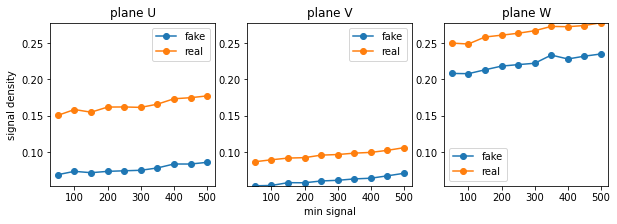

In [10]:
density = 'l0 density mean'
ymin, ymax = df[density].min(), df[density].max()
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, (plane, ax) in enumerate(zip(planes, axes)):
    for c in ['fake', 'real']:
        df_sel = df[ (df['plane'] == plane) & (df['class'] == c)].copy().sort_values(by='min signal')
        x = df_sel['min signal'].values
        y = df_sel[density].values
        ax.plot(x, y, 'o-', label=f'{c}')
        ax.set_ylim([ymin, ymax])
        ax.set_title(f'plane {plane}')
        if i == 0:
            ax.set_ylabel('signal density')
        if i == 1:
            ax.set_xlabel('min signal')
        ax.legend()

### Mean L1 density

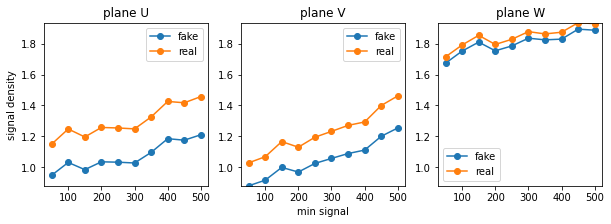

In [11]:
density = 'l1 density mean'
ymin, ymax = df[density].min(), df[density].max()
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, (plane, ax) in enumerate(zip(planes, axes)):
    for c in ['fake', 'real']:
        df_sel = df[ (df['plane'] == plane) & (df['class'] == c)].copy().sort_values(by='min signal')
        x = df_sel['min signal'].values
        y = df_sel[density].values
        ax.plot(x, y, 'o-', label=f'{c}')
        ax.set_ylim([ymin, ymax])
        ax.set_title(f'plane {plane}')
        if i == 0:
            ax.set_ylabel('signal density')
        if i == 1:
            ax.set_xlabel('min signal')
        ax.legend()

## Histogram

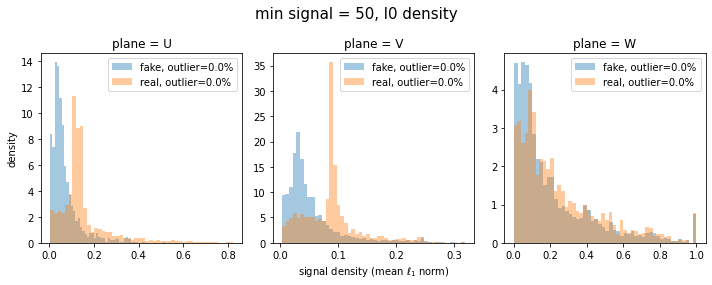

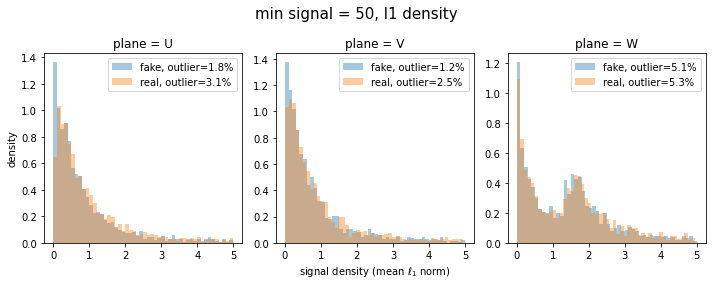

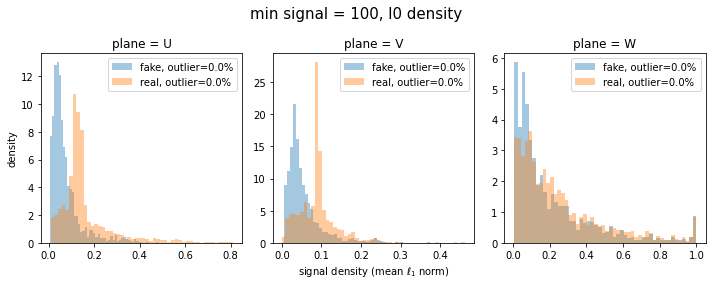

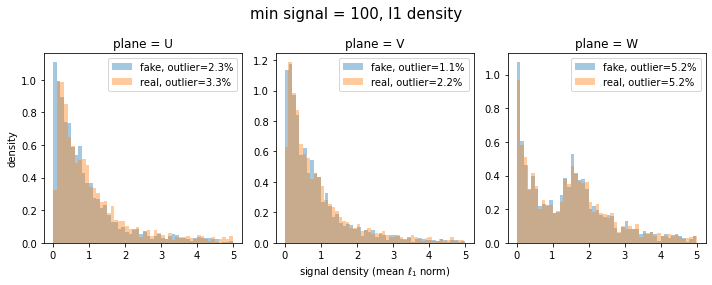

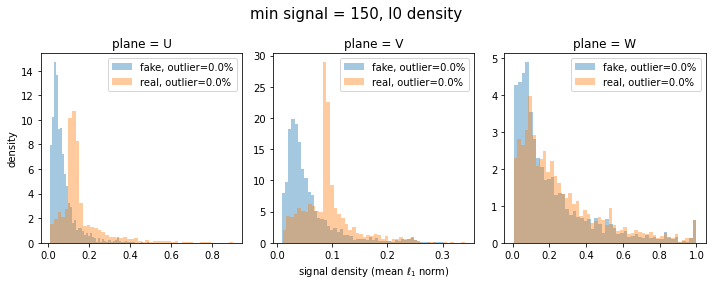

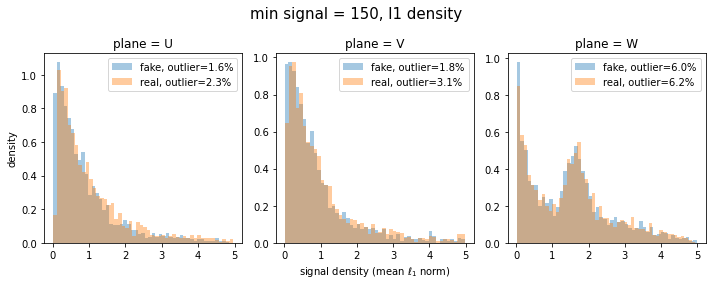

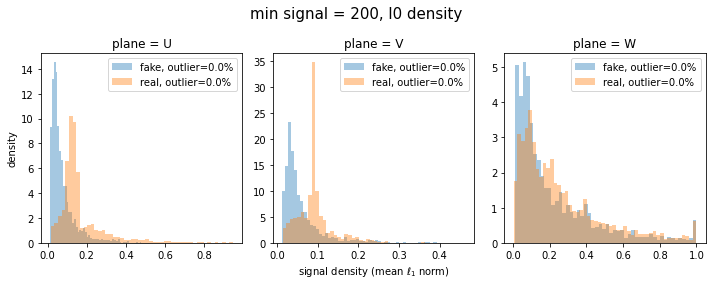

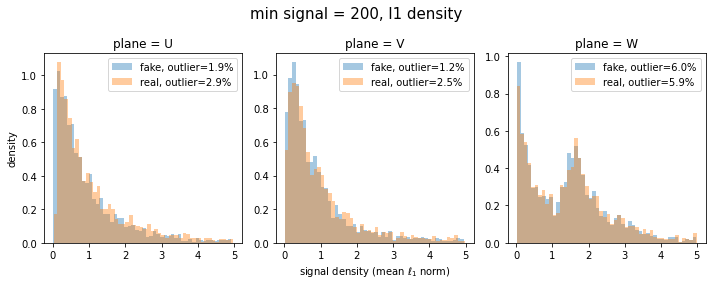

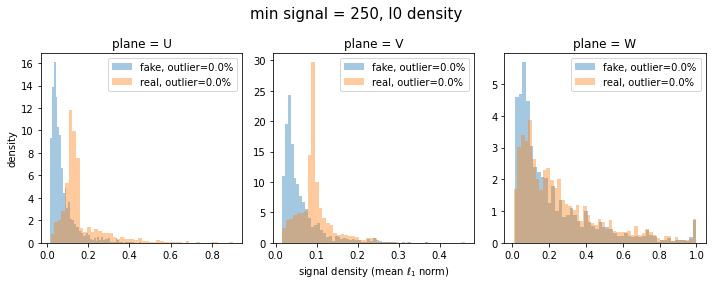

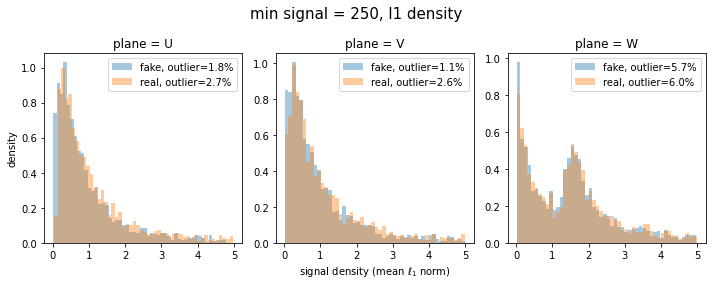

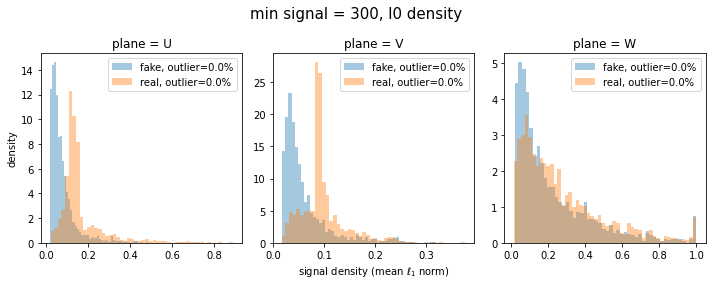

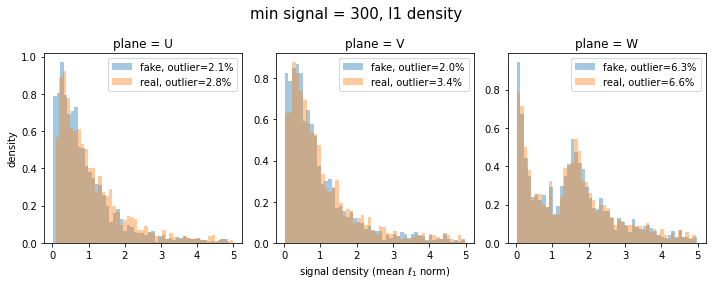

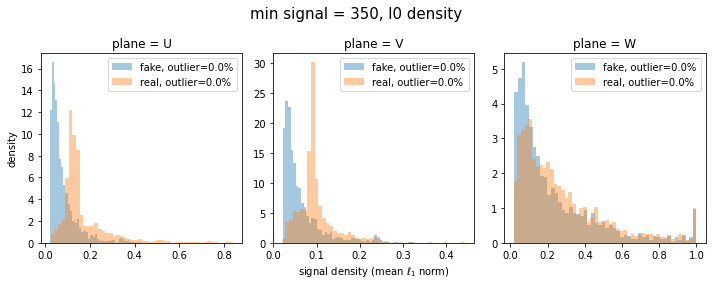

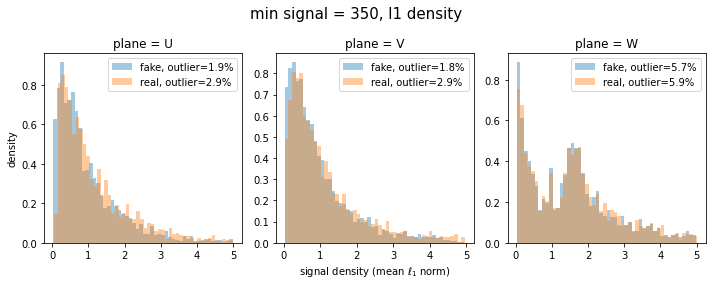

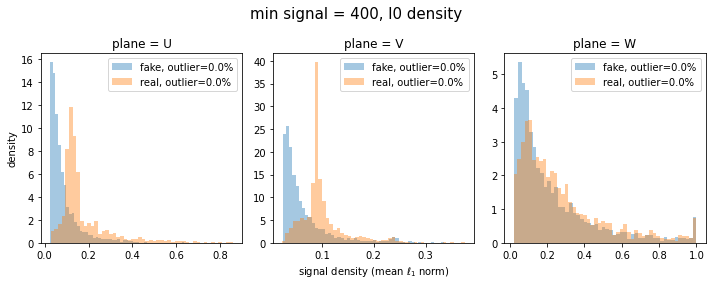

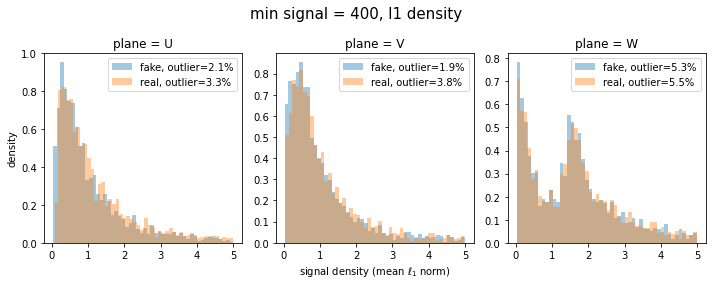

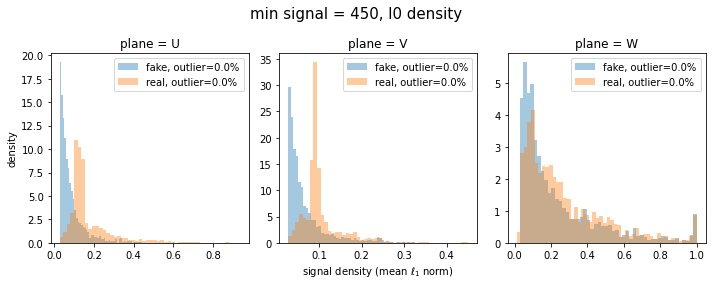

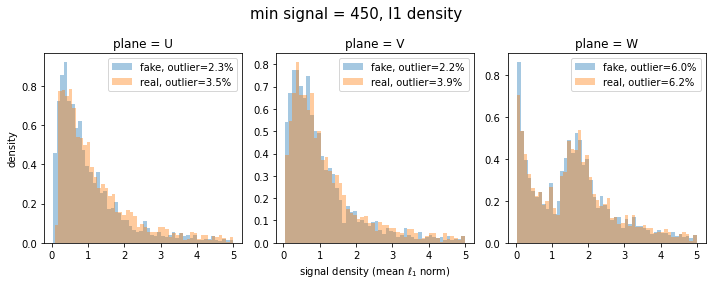

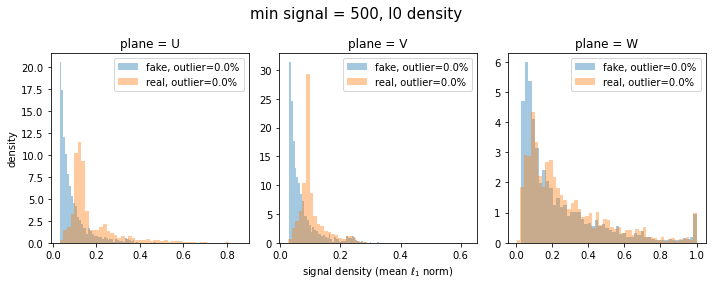

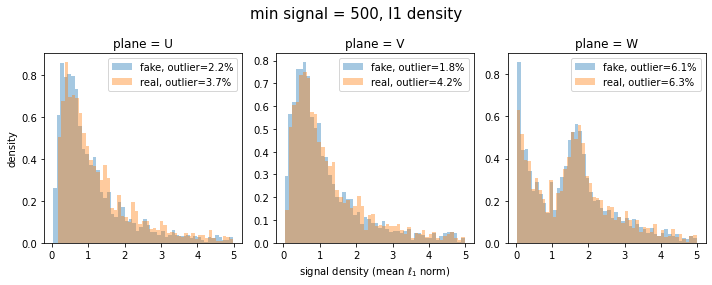

In [12]:
for min_signal in np.arange(50, 550, 50):
    # print(min_signal)
    
    for density in ['l0 density', 'l1 density']:
        fig, axes = plt.subplots(1, 3, figsize=(10, 4))
        for i, (plane, ax) in enumerate(zip(planes, axes)):
            for c in ['fake', 'real']:
                fname = f'{result_folder}/rnd_crop_{min_signal}_{plane}_{c}.csv'
                stat = pd.read_csv(fname)[density].values
                outlier = (stat > 5).sum() / len(stat)
                stat = stat[stat < 5]

                ax.hist(stat, label=f'{c}, outlier={outlier * 100:.1f}%', bins=50, alpha=.4, density=True)
                # ax.hist(stat, label=f'{c}', bins=50, alpha=.4, density=True)
                ax.legend()
                if i == 0:
                    ax.set_ylabel('density')
                if i == 1:
                    ax.set_xlabel('signal density (mean $\ell_1$ norm)')
                ax.set_title(f'plane = {plane}')
            plt.suptitle(f'min signal = {min_signal}, {density}', fontsize=15)
            plt.tight_layout()

## Plot images with lowest density

      l0 density  l1 density  min  max                                 image
1540    0.003052    0.052429  -45   59  batch_00211_protodune-orig-1-3-U.npz
1163    0.003113    0.012146  -15    0  batch_00246_protodune-orig-6-5-U.npz
943     0.003113    0.005371   -6    0  batch_00891_protodune-orig-0-0-U.npz
867     0.003174    0.003723   -3    0  batch_00425_protodune-orig-1-1-U.npz
637     0.003235    0.003235   -1    0  batch_00582_protodune-orig-0-3-U.npz


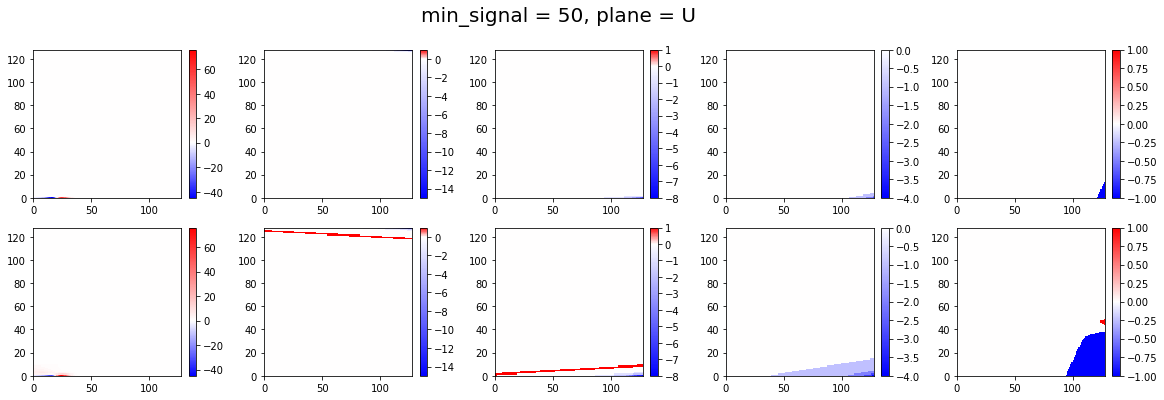

      l0 density  l1 density  min  max                                 image
1153    0.003052    0.007080    0   12  batch_00038_protodune-orig-9-4-V.npz
967     0.003052    0.030151  -27    1  batch_00443_protodune-orig-1-1-V.npz
1904    0.003052    0.030151  -50    5  batch_00545_protodune-orig-7-2-V.npz
1577    0.003113    0.040710    0   51  batch_00214_protodune-orig-8-0-V.npz
1231    0.003113    0.019653    0   36  batch_00312_protodune-orig-8-5-V.npz


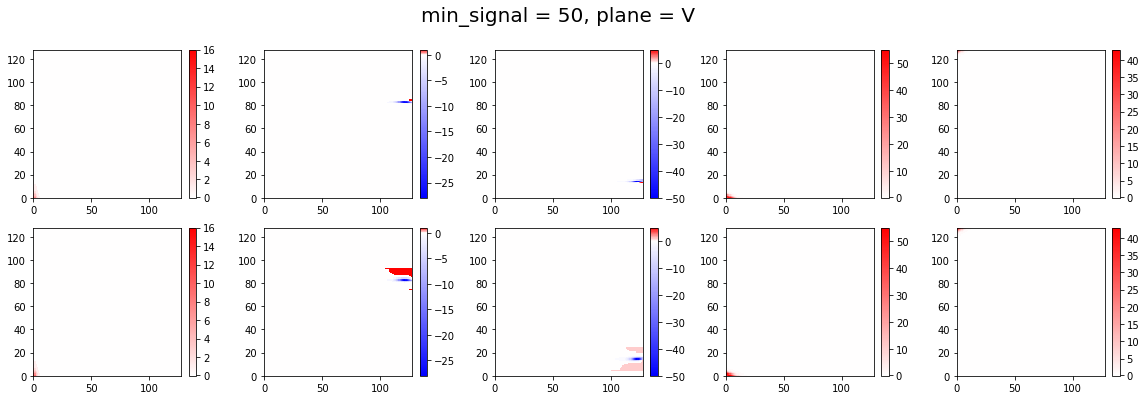

     l0 density  l1 density  min  max                                 image
704    0.003235    0.003235    0    1  batch_00938_protodune-orig-8-4-W.npz
652    0.003357    0.003357   -1    0  batch_00299_protodune-orig-0-2-W.npz
291    0.003479    0.003479   -1    0  batch_00514_protodune-orig-3-3-W.npz
335    0.003479    0.004089   -3    0  batch_00982_protodune-orig-8-0-W.npz
74     0.003540    0.003540    0    1  batch_00479_protodune-orig-5-3-W.npz


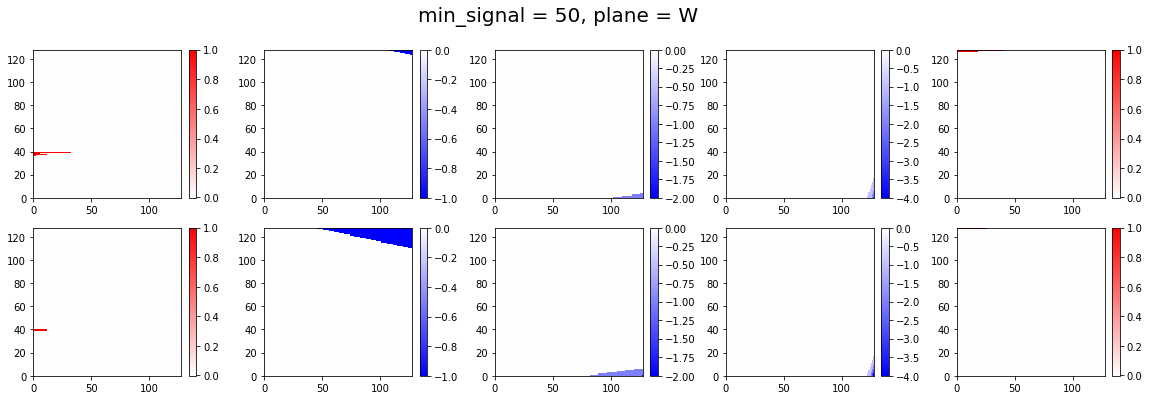

      l0 density  l1 density  min  max                                 image
1921    0.006165    0.043457    0   33  batch_00240_protodune-orig-6-3-U.npz
634     0.006165    0.059814  -18   42  batch_00708_protodune-orig-8-0-U.npz
605     0.006226    0.083191  -23   49  batch_00261_protodune-orig-8-4-U.npz
1468    0.006226    0.021729  -30    0  batch_00779_protodune-orig-6-3-U.npz
1676    0.006348    0.063965  -17   44  batch_00031_protodune-orig-9-2-U.npz


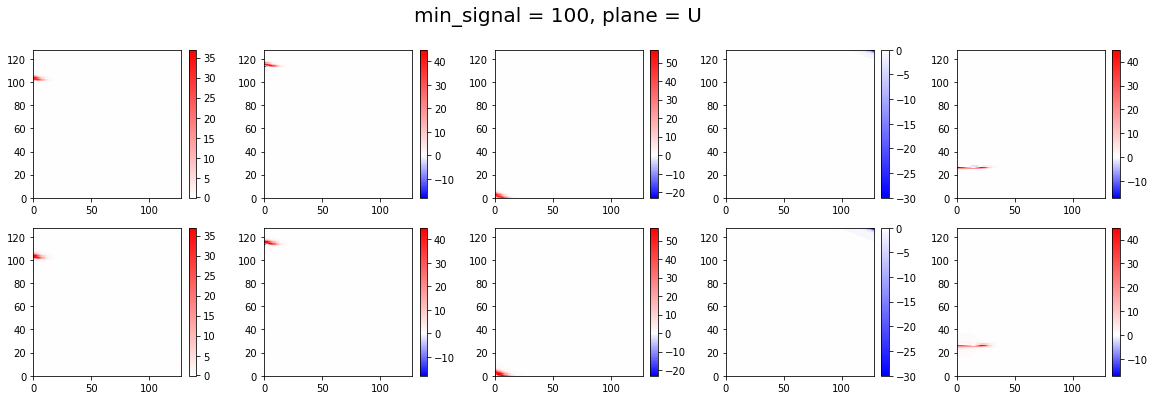

     l0 density  l1 density  min  max                                 image
399    0.006104    0.145447  -62   67  batch_00781_protodune-orig-5-4-V.npz
965    0.006287    0.055603    0   44  batch_00364_protodune-orig-8-1-V.npz
505    0.006287    0.138733  -59   65  batch_00167_protodune-orig-4-1-V.npz
358    0.006348    0.073120  -25   29  batch_00804_protodune-orig-8-1-V.npz
79     0.006348    0.076477  -25   28  batch_00330_protodune-orig-9-5-V.npz


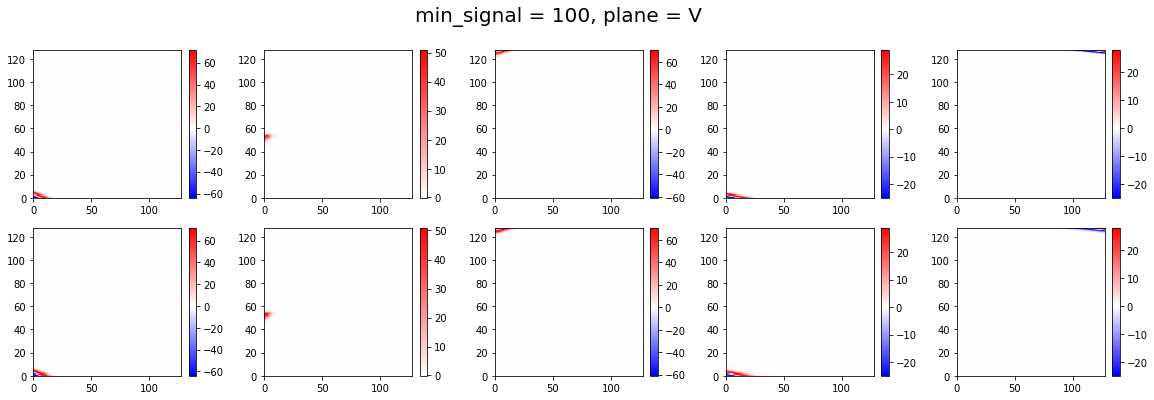

      l0 density  l1 density  min  max                                 image
303     0.006104    0.017944  -26    0  batch_00447_protodune-orig-7-2-W.npz
289     0.006104    0.006165   -2    0  batch_00817_protodune-orig-6-4-W.npz
1351    0.006104    0.006165   -2    0  batch_00255_protodune-orig-3-5-W.npz
487     0.006165    0.006165   -1    0  batch_00095_protodune-orig-2-0-W.npz
1217    0.006226    0.184326 -133    0  batch_00867_protodune-orig-8-3-W.npz


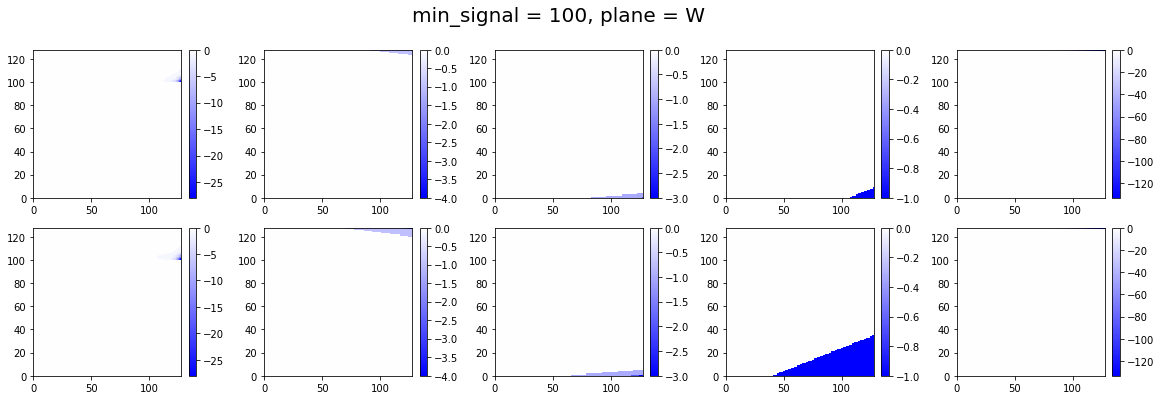

      l0 density  l1 density  min  max                                 image
467     0.009155    0.124756  -36   49  batch_00566_protodune-orig-5-5-U.npz
1063    0.009216    0.099609    0   81  batch_00882_protodune-orig-6-4-U.npz
752     0.009277    0.023987   -3    4  batch_00013_protodune-orig-6-2-U.npz
217     0.009277    0.051270  -33   10  batch_00953_protodune-orig-1-3-U.npz
1167    0.009338    0.074341  -28   34  batch_00989_protodune-orig-4-1-U.npz


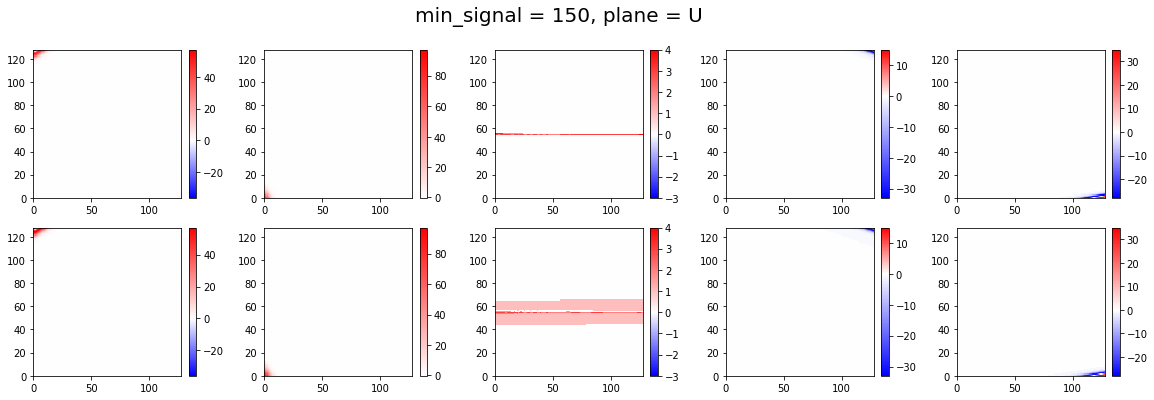

      l0 density  l1 density  min  max                                 image
184     0.009155    0.093201  -19   22  batch_00041_protodune-orig-9-5-V.npz
768     0.009216    0.116028  -22   26  batch_00723_protodune-orig-2-1-V.npz
1288    0.009277    0.092468  -22   29  batch_00399_protodune-orig-7-0-V.npz
309     0.009277    0.219116  -45   78  batch_00745_protodune-orig-4-2-V.npz
1434    0.009460    0.101074  -26   30  batch_00377_protodune-orig-9-0-V.npz


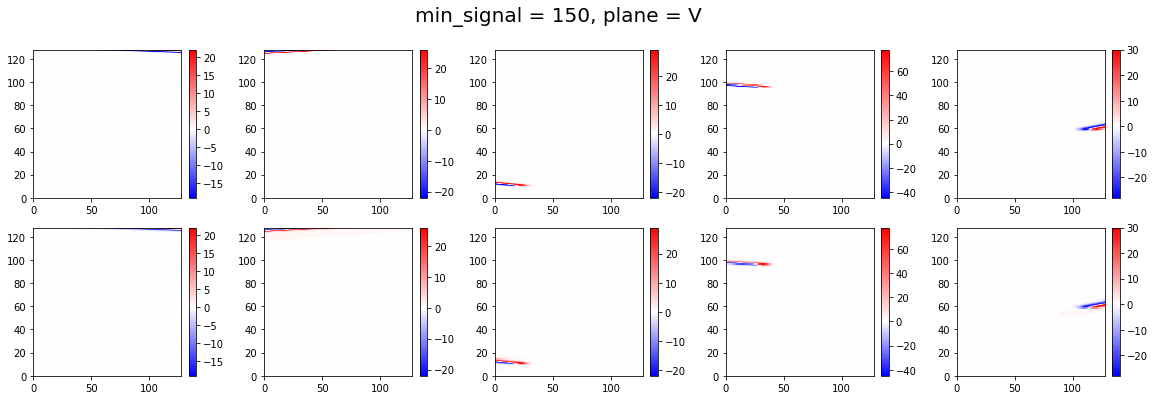

      l0 density  l1 density  min  max                                 image
1786    0.009155    0.012817  -17    0  batch_00016_protodune-orig-7-3-W.npz
399     0.009155    0.236450 -105    0  batch_00207_protodune-orig-1-5-W.npz
786     0.009277    0.009277   -1    0  batch_00462_protodune-orig-0-3-W.npz
468     0.009338    0.504944 -184    1  batch_00315_protodune-orig-9-3-W.npz
1370    0.009705    0.009705    0    1  batch_00963_protodune-orig-3-2-W.npz


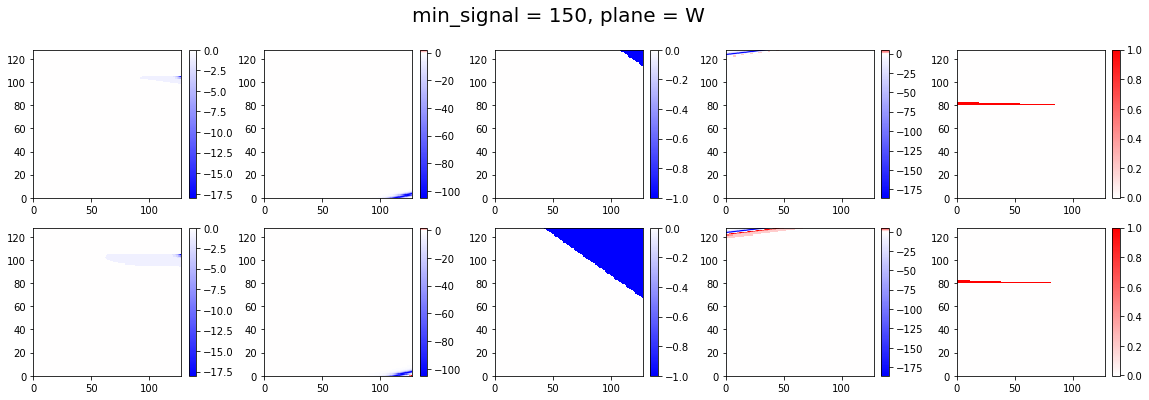

      l0 density  l1 density  min  max                                 image
1857    0.012207    0.207947  -74   75  batch_00078_protodune-orig-4-5-U.npz
1813    0.012207    0.166260  -26   33  batch_00399_protodune-orig-4-0-U.npz
23      0.012268    0.119324  -51   39  batch_00064_protodune-orig-3-1-U.npz
1375    0.012512    0.014099    0    2  batch_00171_protodune-orig-4-1-U.npz
358     0.012512    0.326233  -56   91  batch_00698_protodune-orig-3-4-U.npz


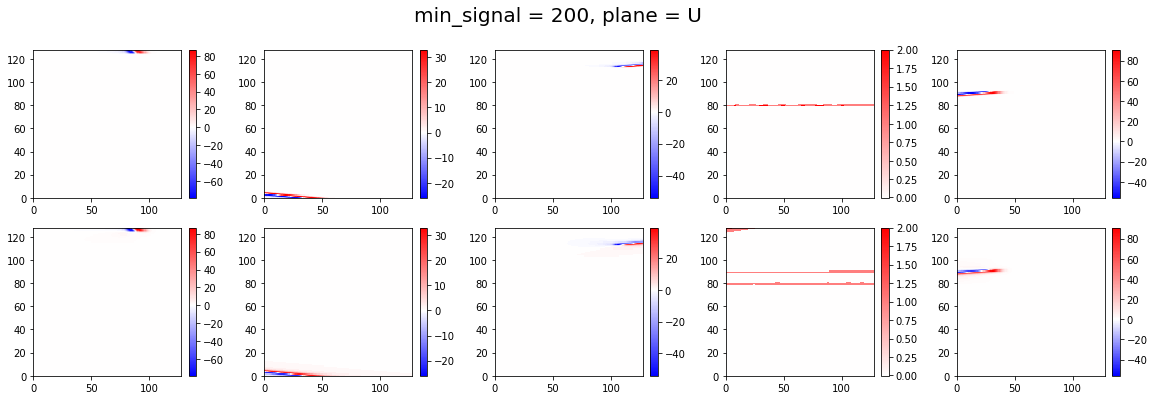

      l0 density  l1 density  min  max                                 image
1969    0.012207    0.206177  -46   39  batch_00851_protodune-orig-8-0-V.npz
1173    0.012207    0.134949  -16   41  batch_00018_protodune-orig-4-4-V.npz
1025    0.012268    0.269226  -49   55  batch_00186_protodune-orig-0-1-V.npz
906     0.012329    0.249695  -50   55  batch_00745_protodune-orig-1-5-V.npz
746     0.012390    0.012390    0    1  batch_00250_protodune-orig-9-3-V.npz


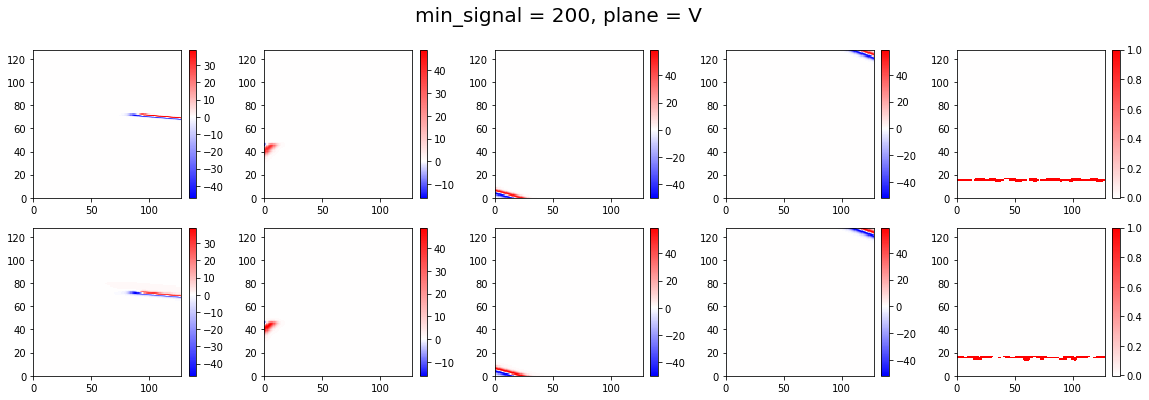

      l0 density  l1 density  min  max                                 image
201     0.012451    0.449524  -99    0  batch_00056_protodune-orig-2-0-W.npz
261     0.012451    0.312134 -149    2  batch_00239_protodune-orig-5-5-W.npz
240     0.012634    0.324036  -81    0  batch_00560_protodune-orig-9-1-W.npz
1530    0.012756    0.233215 -111    0  batch_00070_protodune-orig-5-1-W.npz
864     0.013000    0.555908 -178    2  batch_00118_protodune-orig-4-0-W.npz


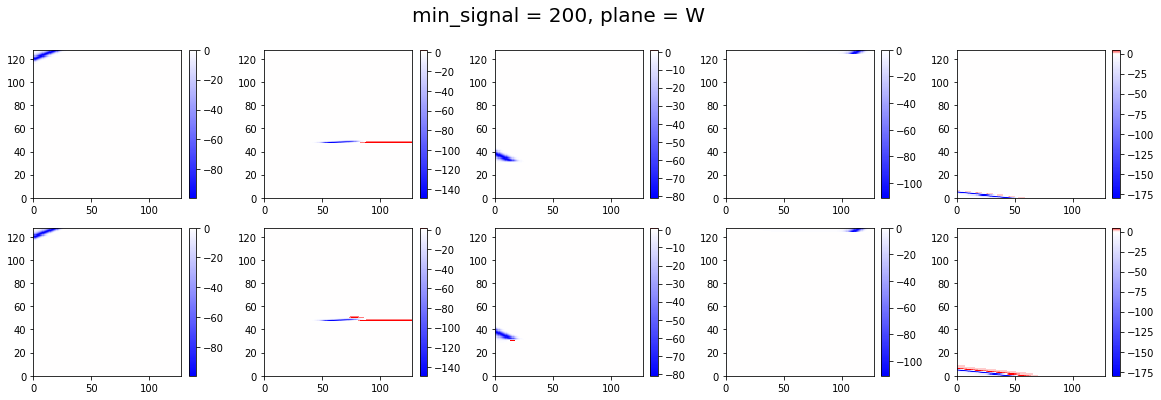

      l0 density  l1 density  min  max                                 image
1957    0.015259    0.015259    0    1  batch_00199_protodune-orig-4-5-U.npz
75      0.015381    0.021667    0    2  batch_00461_protodune-orig-8-0-U.npz
418     0.015381    0.120911  -63   50  batch_00248_protodune-orig-5-4-U.npz
446     0.015442    0.015442    0    1  batch_00861_protodune-orig-7-4-U.npz
1287    0.015625    0.016174    0    2  batch_00359_protodune-orig-7-0-U.npz


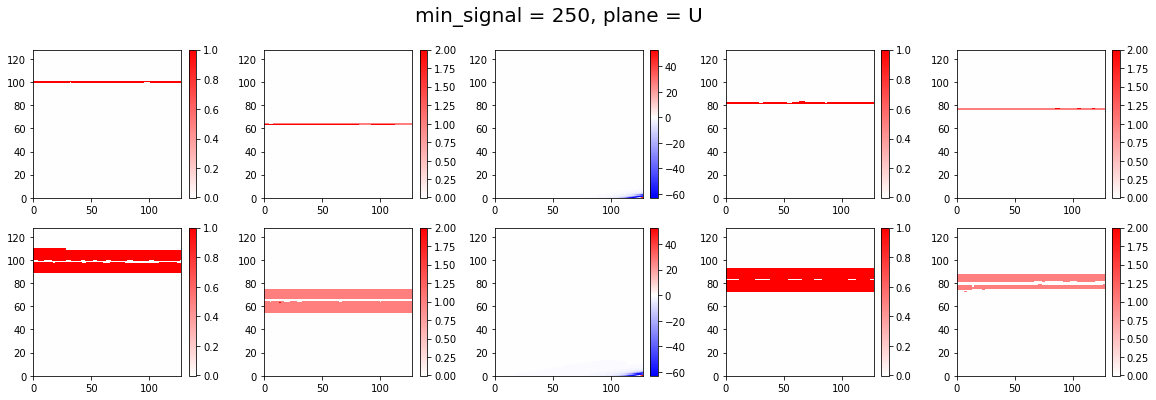

      l0 density  l1 density  min  max                                 image
776     0.015259    0.240051  -41   45  batch_00076_protodune-orig-4-2-V.npz
1469    0.015259    0.015503    0    2  batch_00208_protodune-orig-2-2-V.npz
772     0.015320    0.016113    0    2  batch_00532_protodune-orig-6-4-V.npz
728     0.015381    0.273560  -38   43  batch_00808_protodune-orig-3-1-V.npz
1202    0.015442    0.179016  -27   31  batch_00263_protodune-orig-7-1-V.npz


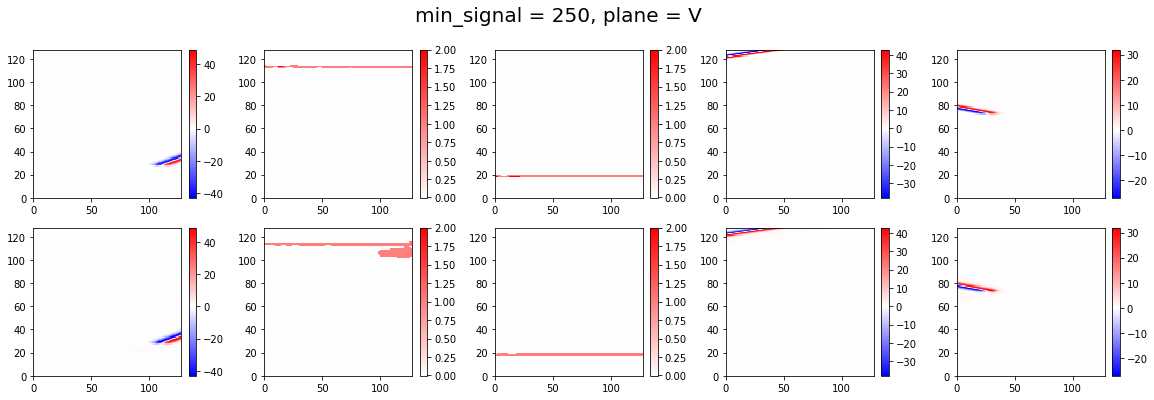

      l0 density  l1 density  min  max                                 image
270     0.015259    0.480103  -87    0  batch_00546_protodune-orig-2-4-W.npz
1408    0.015259    1.704468 -284    0  batch_00312_protodune-orig-5-1-W.npz
784     0.015259    0.015259    0    1  batch_00157_protodune-orig-6-0-W.npz
1233    0.015442    0.302368 -189   10  batch_00209_protodune-orig-5-3-W.npz
3       0.015625    0.050720    0    6  batch_00108_protodune-orig-1-0-W.npz


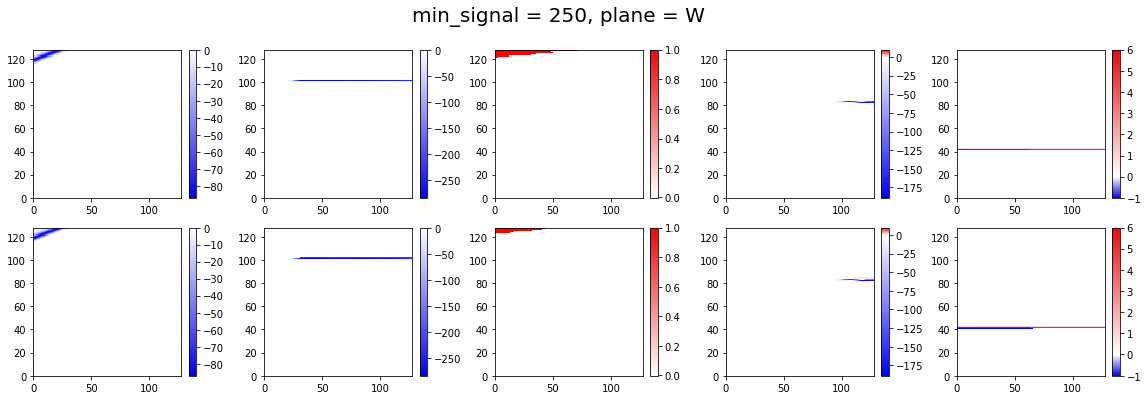

      l0 density  l1 density  min  max                                 image
506     0.018311    0.093262  -44    0  batch_00797_protodune-orig-8-4-U.npz
681     0.018311    0.018311    0    1  batch_00266_protodune-orig-2-0-U.npz
480     0.018372    0.279297  -36   47  batch_00331_protodune-orig-2-4-U.npz
1400    0.018372    0.216858  -27   37  batch_00781_protodune-orig-8-1-U.npz
1630    0.018433    0.242798  -24   62  batch_00236_protodune-orig-7-3-U.npz


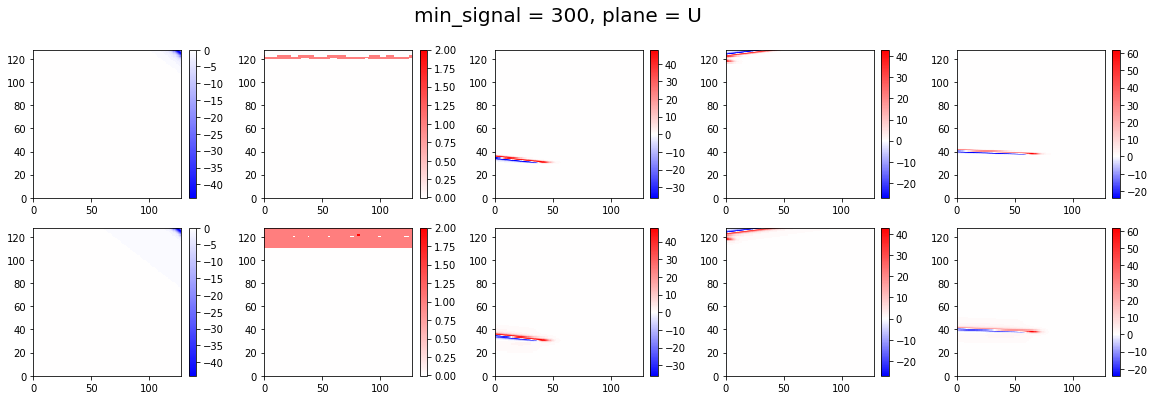

      l0 density  l1 density  min  max                                 image
555     0.018311    0.071899   -6    8  batch_00152_protodune-orig-6-4-V.npz
1974    0.018311    0.044434   -4    5  batch_00073_protodune-orig-2-4-V.npz
252     0.018433    0.526794 -120   81  batch_00930_protodune-orig-8-5-V.npz
709     0.018494    0.035278   -2    3  batch_00688_protodune-orig-9-2-V.npz
506     0.018494    0.416321  -52   58  batch_00098_protodune-orig-0-5-V.npz


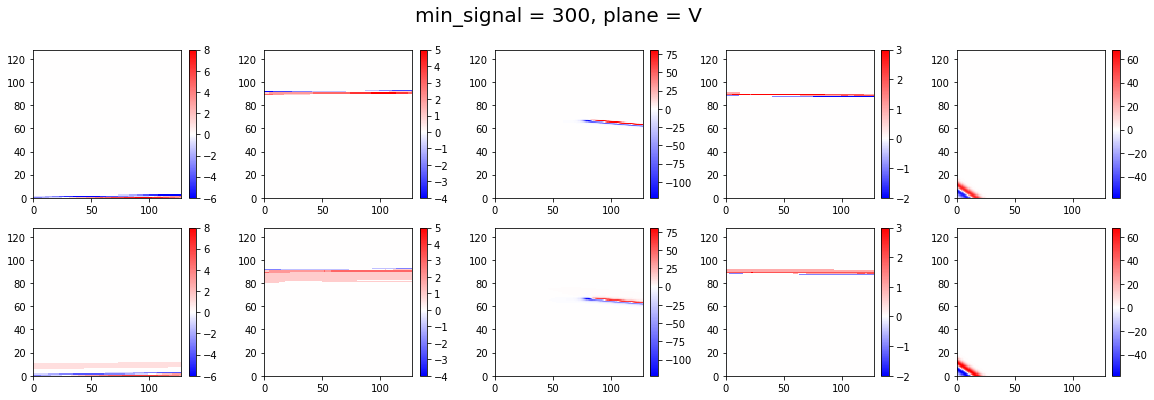

      l0 density  l1 density  min  max                                 image
787     0.018372    0.018372   -1    0  batch_00174_protodune-orig-2-4-W.npz
1725    0.018433    0.026917  -27    0  batch_00461_protodune-orig-5-0-W.npz
941     0.018494    0.302490  -86    0  batch_00741_protodune-orig-7-1-W.npz
1688    0.018494    0.530640 -120    0  batch_00858_protodune-orig-9-4-W.npz
903     0.018555    0.525024  -98    0  batch_00332_protodune-orig-0-1-W.npz


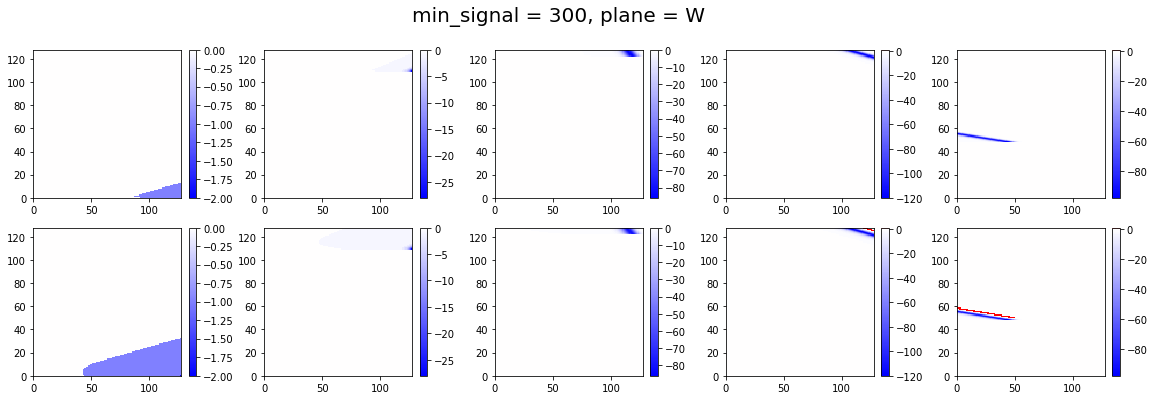

      l0 density  l1 density  min  max                                 image
1928    0.021362    0.240295  -29   33  batch_00333_protodune-orig-7-5-U.npz
679     0.021423    0.069275   -3   25  batch_00045_protodune-orig-4-2-U.npz
63      0.021484    0.172119  -24   26  batch_00389_protodune-orig-3-4-U.npz
1541    0.021545    0.153748  -26   20  batch_00054_protodune-orig-3-5-U.npz
1521    0.021545    0.041504   -2    4  batch_00235_protodune-orig-7-0-U.npz


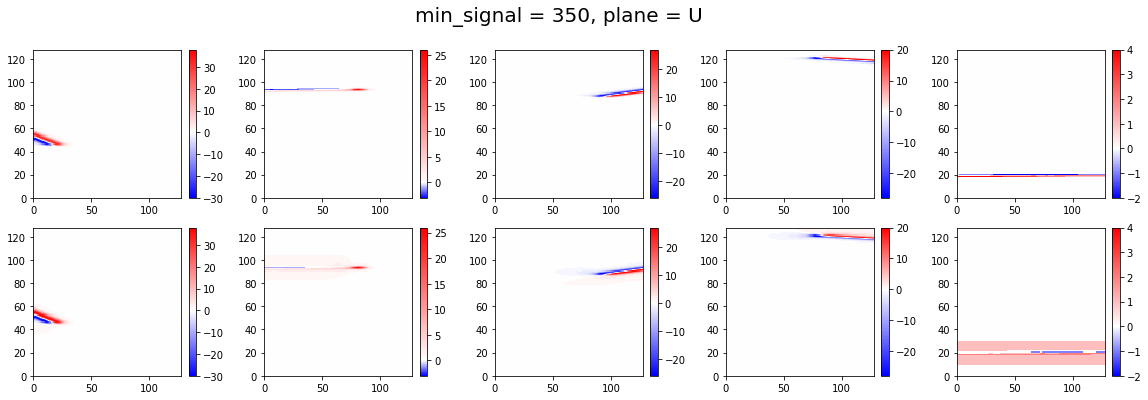

      l0 density  l1 density  min  max                                 image
607     0.021362    0.286499  -28   32  batch_00852_protodune-orig-5-2-V.npz
1883    0.021362    0.037476   -2    3  batch_00006_protodune-orig-2-4-V.npz
397     0.021362    0.053528   -3    5  batch_00692_protodune-orig-8-3-V.npz
1471    0.021423    0.173218  -19   20  batch_00737_protodune-orig-0-2-V.npz
182     0.021423    0.162354  -15   23  batch_00501_protodune-orig-1-0-V.npz


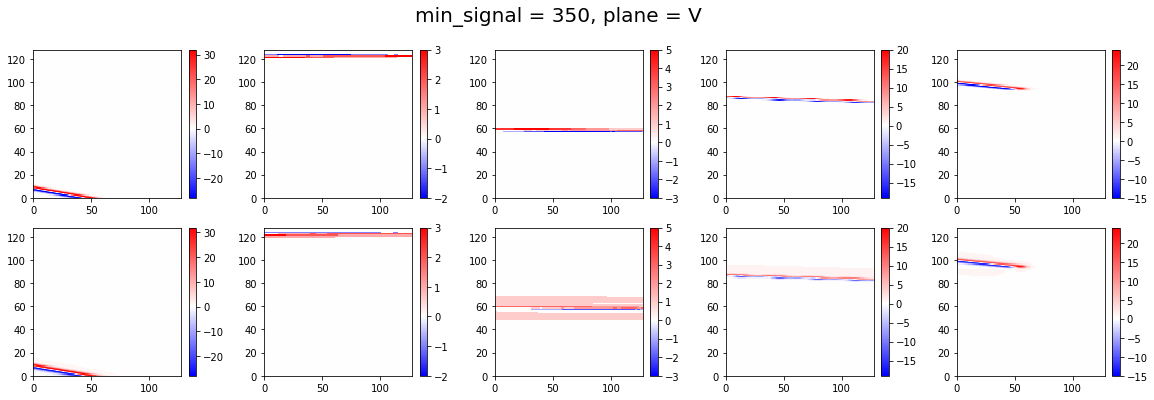

      l0 density  l1 density  min  max                                 image
365     0.021484    0.839172 -246   14  batch_00937_protodune-orig-0-4-W.npz
564     0.021545    0.524963  -98    0  batch_00618_protodune-orig-7-4-W.npz
470     0.021667    0.021667    0    1  batch_00271_protodune-orig-6-2-W.npz
1892    0.021851    0.510132 -124    0  batch_00819_protodune-orig-0-1-W.npz
43      0.022400    0.022400    0    1  batch_00747_protodune-orig-6-3-W.npz


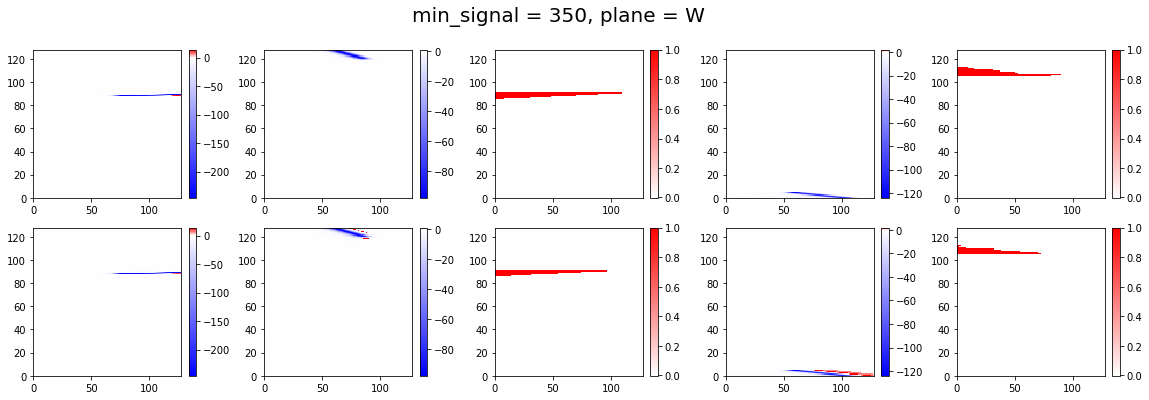

      l0 density  l1 density  min  max                                 image
1327    0.024414    0.404907  -42   44  batch_00923_protodune-orig-8-2-U.npz
23      0.024475    0.315552  -40   48  batch_00578_protodune-orig-2-3-U.npz
1457    0.024475    0.040161   -2    3  batch_00783_protodune-orig-1-0-U.npz
1903    0.024475    0.035339   -1    3  batch_00747_protodune-orig-1-0-U.npz
1377    0.024536    0.093018   -6    8  batch_00099_protodune-orig-2-1-U.npz


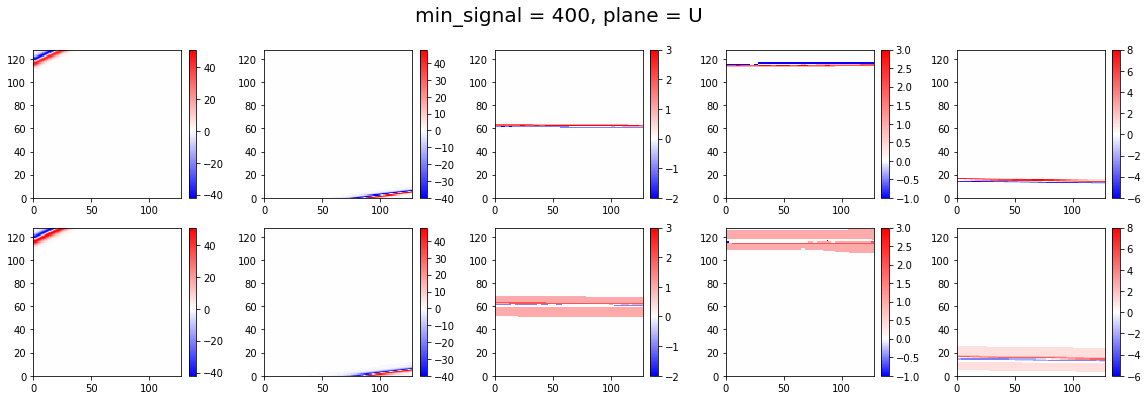

      l0 density  l1 density  min  max                                 image
1027    0.024414    0.278015  -63   24  batch_00095_protodune-orig-6-5-V.npz
694     0.024414    0.086304   -5    7  batch_00854_protodune-orig-7-3-V.npz
1269    0.024475    0.231018  -17   20  batch_00688_protodune-orig-7-4-V.npz
619     0.024475    0.372864  -33   38  batch_00973_protodune-orig-8-0-V.npz
1629    0.024536    0.224304  -17   20  batch_00211_protodune-orig-1-2-V.npz


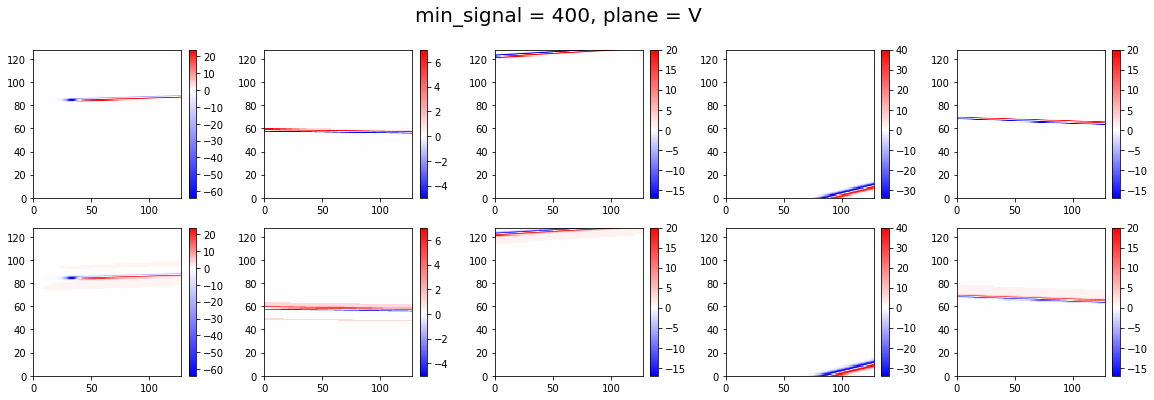

      l0 density  l1 density  min  max                                 image
377     0.024597    0.402222 -103    1  batch_00636_protodune-orig-0-2-W.npz
1732    0.024719    0.595642  -91    0  batch_00408_protodune-orig-6-4-W.npz
1733    0.024841    0.024841   -1    0  batch_00265_protodune-orig-2-2-W.npz
1812    0.024841    1.040527 -107    0  batch_00282_protodune-orig-5-3-W.npz
1071    0.024963    0.791748 -147    2  batch_00496_protodune-orig-0-3-W.npz


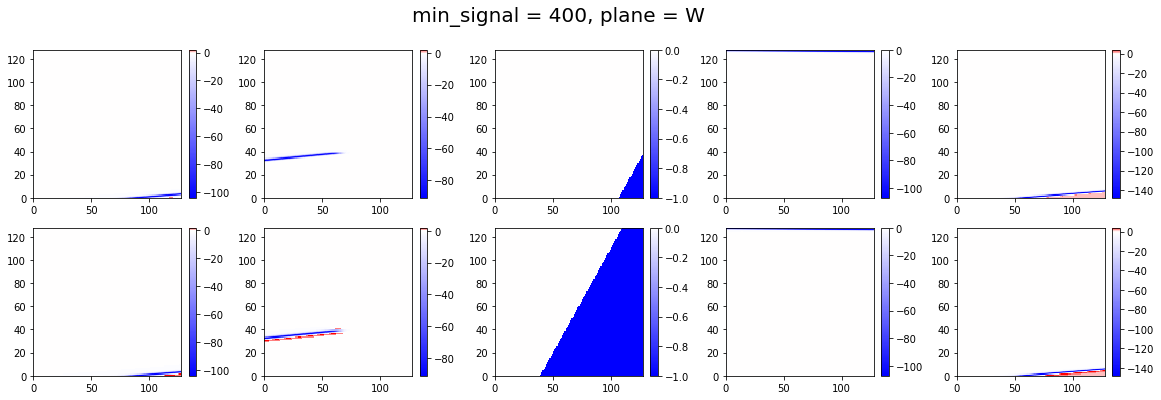

      l0 density  l1 density  min  max                                 image
175     0.027466    0.102783   -5    8  batch_00873_protodune-orig-2-3-U.npz
1203    0.027527    0.073608   -3    6  batch_00856_protodune-orig-1-2-U.npz
1690    0.027527    0.070923   -3    5  batch_00509_protodune-orig-2-3-U.npz
774     0.027588    0.056030    0   11  batch_00540_protodune-orig-8-1-U.npz
836     0.027588    0.230591  -15   18  batch_00498_protodune-orig-8-1-U.npz


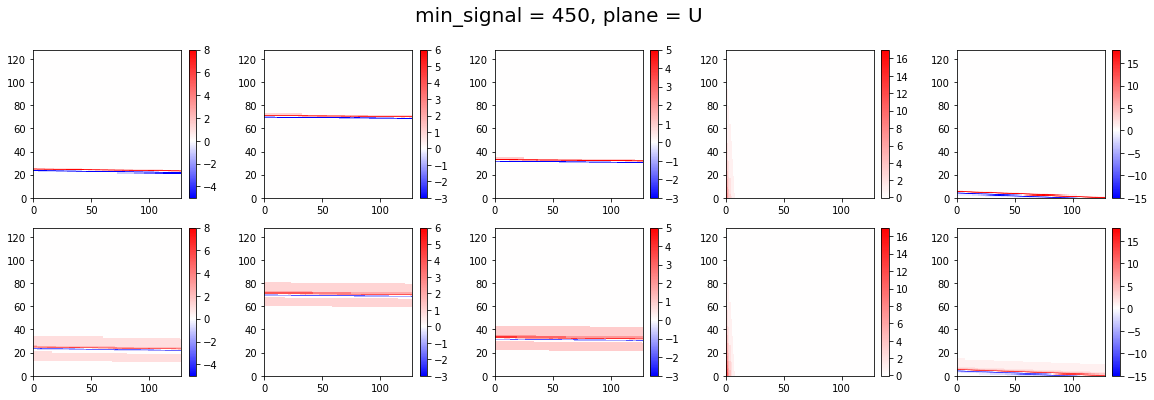

      l0 density  l1 density  min  max                                 image
1907    0.027466    0.055603   -3    4  batch_00125_protodune-orig-8-4-V.npz
424     0.027466    0.077393   -4    6  batch_00774_protodune-orig-3-2-V.npz
1596    0.027466    0.131592   -8   10  batch_00995_protodune-orig-4-4-V.npz
1770    0.027466    0.182251  -11   14  batch_00358_protodune-orig-6-4-V.npz
201     0.027466    0.213196  -14   16  batch_00162_protodune-orig-0-2-V.npz


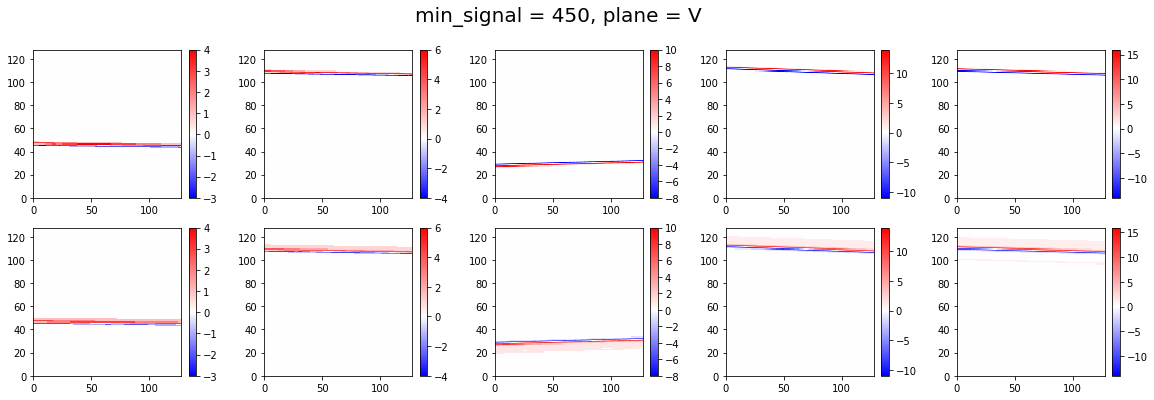

      l0 density  l1 density  min  max                                 image
986     0.027527    0.027527    0    1  batch_00445_protodune-orig-9-5-W.npz
1956    0.028442    2.293335 -294   21  batch_00705_protodune-orig-3-4-W.npz
1043    0.028503    1.114380 -156    0  batch_00748_protodune-orig-0-4-W.npz
1631    0.028687    0.431152 -193    2  batch_00436_protodune-orig-4-0-W.npz
1918    0.028748    0.894226 -109    0  batch_00558_protodune-orig-6-1-W.npz


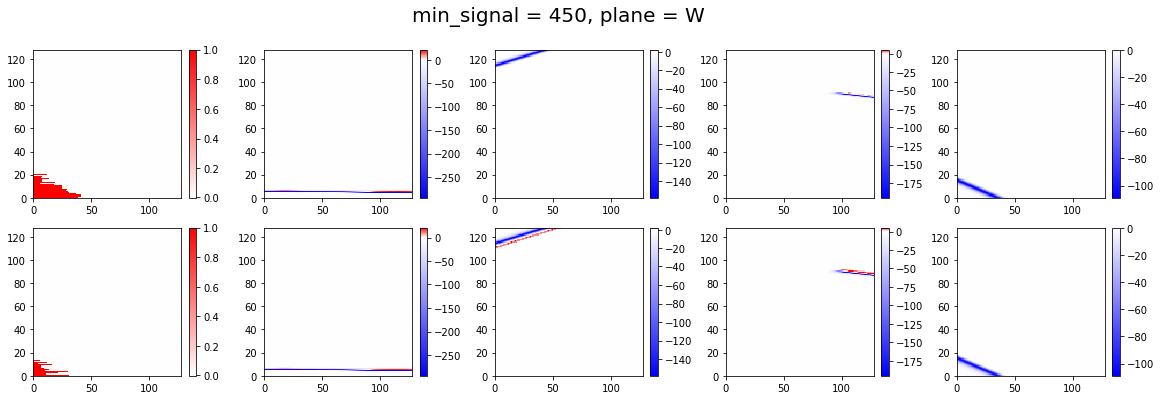

      l0 density  l1 density  min  max                                 image
660     0.030518    0.167664   -9   12  batch_00752_protodune-orig-3-0-U.npz
1391    0.030518    0.105225   -5    7  batch_00839_protodune-orig-3-2-U.npz
1346    0.030579    0.142151   -7   10  batch_00277_protodune-orig-8-0-U.npz
934     0.030579    0.236938  -15   17  batch_00369_protodune-orig-2-2-U.npz
591     0.030640    0.105774   -5    7  batch_00607_protodune-orig-0-0-U.npz


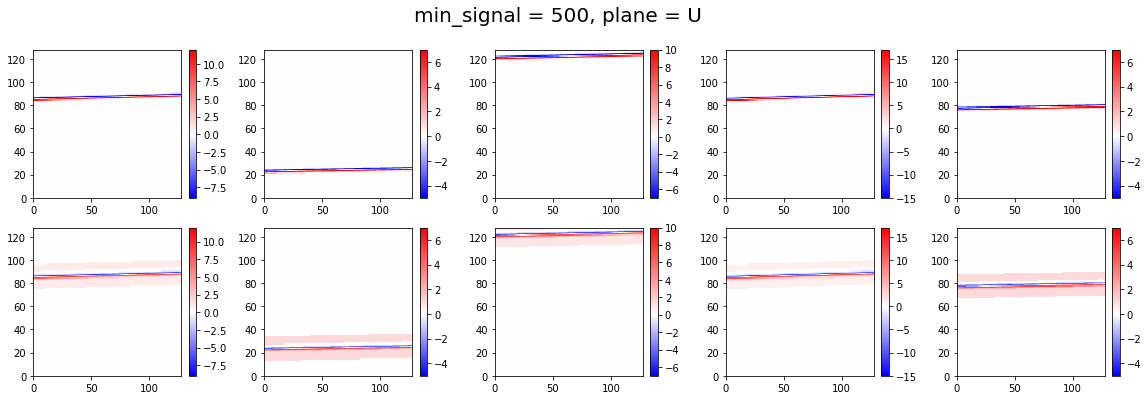

      l0 density  l1 density  min  max                                 image
184     0.030518    0.089783   -4    6  batch_00649_protodune-orig-7-2-V.npz
649     0.030518    0.174744  -10   12  batch_00861_protodune-orig-3-0-V.npz
87      0.030518    0.576660  -43   48  batch_00195_protodune-orig-7-4-V.npz
1449    0.030518    0.108582   -5    7  batch_00969_protodune-orig-6-2-V.npz
1787    0.030518    0.094360   -5    6  batch_00559_protodune-orig-7-5-V.npz


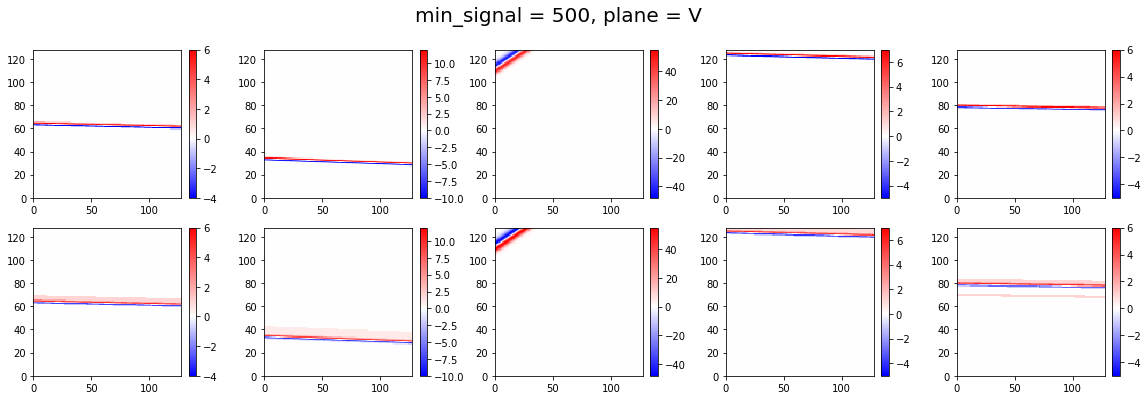

      l0 density  l1 density  min  max                                 image
1500    0.030579    0.682922  -82    0  batch_00243_protodune-orig-4-1-W.npz
755     0.030640    1.157532 -279   13  batch_00345_protodune-orig-1-2-W.npz
751     0.030884    0.030884    0    1  batch_00983_protodune-orig-8-4-W.npz
1800    0.031006    0.671936 -163    4  batch_00111_protodune-orig-8-2-W.npz
1092    0.031067    0.098083 -124    0  batch_00499_protodune-orig-0-1-W.npz


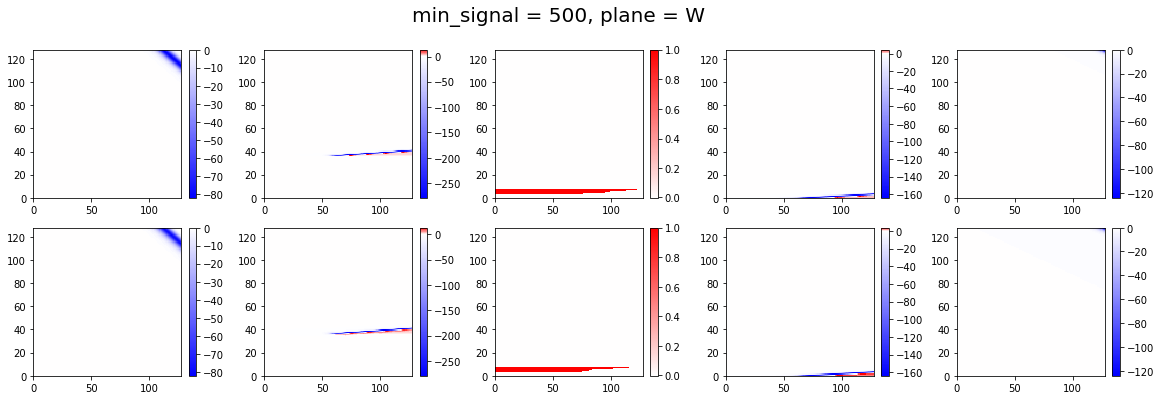

In [57]:
def load_image(image_fname, x, y, x_ws, y_ws, bkg):
    image = np.load(image_fname)
    image = image[image.files[0]]
    image = image[x: x + x_ws, y: y + y_ws] - bkg        
    return image 

density = 'l0 density'
num_lowest = 5
cmap = 'bwr'

for min_signal in np.arange(50, 550, 50):
    df_window = pd.read_csv(f'{path_base}/windows_{min_signal}-128x128.csv', index_col=0)
    
    for i, plane in enumerate(planes):
        fname = f'{result_folder}/rnd_crop_{min_signal}_{plane}_fake.csv'
        sel = pd.read_csv(fname).sort_values(by=density)[:num_lowest]
        print(sel)
        image_fnames = sel['image'].values
        
        images_fake, images_real = [], []
        for image_fname in image_fnames:
            image_fname_fake = Path(data_path)/f'fake/{image_fname}'
            image_fname_real = Path(data_path)/f'real/{image_fname}'
            # print(image_fname_fake)
            # print(image_fname_real)

            row = df_window[df_window.image == image_fname]
            x, y, x_ws, y_ws, bkg = row.values[0][-5:]
            image_fake = load_image(image_fname_fake, x, y, x_ws, y_ws, bkg)
            image_real = load_image(image_fname_real, x, y, x_ws, y_ws, bkg)
            images_fake.append(image_fake)
            images_real.append(image_real)
            
        vmin_fake = [image.min() for image in images_fake]
        vmax_fake = [image.max() for image in images_fake]
        vmin_real = [image.min() for image in images_real]
        vmax_real = [image.max() for image in images_real]
        vmins = [min(a, b) for a, b in zip(vmin_fake, vmin_real)]
        vmaxs = [max(a, b) for a, b in zip(vmax_fake, vmax_real)]
        # print(vmin_fake, vmax_fake)
        
        fig, axes = plt.subplots(2, num_lowest, figsize=(4 * num_lowest, 3 * 2))
        
        for i, (image, ax) in enumerate(zip(images_fake, axes[0])):
            ax.set_aspect(1)
            vmin, vmax = vmins[i], vmaxs[i]
            if vmin == 0:
                divnorm = mcolors.TwoSlopeNorm(vmin=-1e-4, vcenter=0, vmax=vmax)
            elif vmax == 0:
                divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=1e-4)
            else:
                divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            im = ax.pcolormesh(image, cmap=cmap, norm=divnorm)
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
        for i, (image, ax) in enumerate(zip(images_real, axes[1])):
            ax.set_aspect(1)
            vmin, vmax = vmins[i], vmaxs[i]
            if vmin == 0:
                divnorm = mcolors.TwoSlopeNorm(vmin=-1e-4, vcenter=0, vmax=vmax)
            elif vmax == 0:
                divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=1e-4)
            else:
                divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            im = ax.pcolormesh(image, cmap=cmap, norm=divnorm)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
        plt.suptitle(f'min_signal = {min_signal}, plane = {plane}', fontsize=20)
        plt.show()
        plt.close()